# 10.3 Time Variability


Many X-ray astronomical sources exhibit time variability. The **SIMPUT** format allows the characterization of this variability in several ways:

- **As a light curve**: This is energy dependent and specified through an ASCII file (parameter `LCFile`). The file should contain two numbers per row: the time and the flux at that time. Ensure the file ends with a newline.
  
- **As a stochastic process**: Defined through its power spectrum, this is represented by an ASCII file where each row contains a frequency and the power at that frequency.

- **As parameters of the power spectrum**: The power spectrum is defined by the sum of several Lorentzians and a zero-centered low-frequency Quasi-Periodic Oscillation (QPO).

Additionally, the **SIMPUT** format allows the specification of source variability through energy-dependent pulse profiles.

The **Time Variability** extension can be used in the SIMPUT format to describe the time dependence of the source flux. It can also be used to create a dynamic spectrum where the source's spectral model varies with time.

The **TIMING** extension in SIMPUT files is designed to define a spectrum at a specific time or phase for a periodic source, with the relative flux of the source for the respective spectrum. 

- When using this extension, the `SRC_CAT` should **not** contain a `'NULL'` in the `Spectrum` column.
- The name of the timing extension can be arbitrary, as long as it is correctly referenced in the SIMPUT source catalog. For simplicity, we will refer to it as **TIMING**, which is the default.


In [1]:
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import time
import tempfile
from funcs import run_comm

from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from datetime import datetime
from subprocess import check_call, STDOUT
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

plt.style.use(astropy_mpl_style)


In [2]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
SIXTE = os.environ["SIXTE"]
xmldir = f"{SIXTE}/share/sixte/instruments/athena-wfi/wfi_wo_filter"

## 10.3.1 Ligth curve

#### A light curve in ASCII format needs to be created. The first column defines the time in seconds, and the second column represents the relative flux. An example light curve can be downloaded [here](https://www.sternwarte.uni-erlangen.de/~sixte/downloads/example_lightcurve.dat).  
#### Alternatively, you can create a light curve like this:

In [3]:
# Define data for the light curve
time_data = [
    0.0, 1.592568e+06, 4.746168e+06, 6.606792e+06, 8.025912e+06, 
    9.728856e+06, 1.1179512e+07, 1.2661704e+07, 1.4490792e+07, 
    1.7360568e+07, 2.0545704e+07, 2.0671848e+07, 2.1617928e+07, 
    2.4771528e+07, 3.1078728e+07
]
flux_data = [
    1.0, 1.1710184667753536, 1.3358780211173131, 1.3293381514300098, 1.4909655685166552,
    1.5980267404433528, 2.153357609878695, 2.39221452151335, 2.4567948412375427, 
    3.458953394676431, 3.6081398507819546, 3.764432206495363, 3.5827559773470936, 
    3.67454568093744, 1.0
]

# Write data to the ASCII file with a blank last line
filename = "example_lightcurve.dat"
with open(filename, 'w') as file:
    for time, flux in zip(time_data, flux_data):
        file.write(f"{time:.7e}  {flux}\n")

print(f"Light curve data has been written to {filename}.")

Light curve data has been written to example_lightcurve.dat.


### `simputfile` call with the spectrum *mcrab.xcm* (same as the one created in *tutorial-general-intro.ipynb*) with ligth curve

In [4]:
AllModels.clear()
base = "mcrab"
xcm = f"{base}.xcm"
# define XSPEC parameters
Xset.abund = "wilm"
Xset.cosmo = "70 0. 0.73"
Xset.xsect = "bcmc"
mcmod = Model("phabs*pegpwrlw")
mcmod.phabs.nH = 0.2
mcmod.pegpwrlw.PhoIndex = 2.05
mcmod.pegpwrlw.eMin = 2.
mcmod.pegpwrlw.eMax = 10.
mcmod.pegpwrlw.norm = 21.6
mcmod.show()
AllModels.calcFlux("2. 10.")
simput_flux = AllModels(1).flux[0]

 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      frozen
   4    2   pegpwrlw   eMax       keV      10.0000      frozen
   5    2   pegpwrlw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    0.200000     +/-  0.0          
   2    2   pegpwrlw   PhoIndex 

In [5]:
clobber = True
# If clobber is true and the file exists, it will be removed before creating a new one.
if os.path.exists(xcm):
    if clobber:
        os.remove(xcm)
    else:
        raise Exception(f"Xspec file ({xcm}) already exists: it will not be overwritten") 
Xset.save(xcm)

In [6]:
simput_lightcurve = f'{base}_lightcurve.fits'
# Simputfile with the lightcurve
comm = (f"simputfile Simput={simput_lightcurve} Src_Name=first RA=0.0  Dec=0.0 srcFlux={simput_flux} " + 
        f"Elow=0.1 Eup=15 NBins=1000 logEgrid=yes Emin=2 Emax=10 MJDREF=55000 " +
        f"LCFile=example_lightcurve.dat XSPECFile={xcm} clobber=True")
#print(comm)
run_comm(comm, "Creating simputfile with light curve")


Creating simputfile with light curve
simputfile Simput=mcrab_lightcurve.fits Src_Name=first RA=0.0  Dec=0.0 srcFlux=2.1306205888361613e-11 Elow=0.1 Eup=15 NBins=1000 logEgrid=yes Emin=2 Emax=10 MJDREF=55000 LCFile=example_lightcurve.dat XSPECFile=mcrab.xcm clobber=True
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Sun Oct 13 18:44:41 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPE

As we are now dealing with time variable effects, we need to specify an absolute time reference. This is done by
setting `MJDREF` to the desired value. **Important:** the simulation (whn you run sixtesim) should be performed by the same `MJDREF` and
the light curve has to cover the full range of the simulated observation.

### Inspect *mcrab_lightcurve.fits*  file and have a look how the light curve is included in the source catalog.
You will notice that the column `TIMING` is now referring to the light curve extension with [TIMING,1].
Having a closer look at the `TIMING` extension we defined, reveals that the light curve is stored as scalar values,
with each row containing one time and flux value.

In [7]:
f = fits.open(simput_lightcurve)
f.info()
f["TIMING"].columns.info()
f.close()

Filename: mcrab_lightcurve.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SRC_CAT       1 BinTableHDU     44   1R x 12C   [J, 32A, D, D, E, E, E, E, E, 32A, 32A, 32A]   
  2  SPECTRUM      1 BinTableHDU     21   1R x 3C   [1PE(1000), 1PE(1000), 48A]   
  3  TIMING        1 BinTableHDU     21   15R x 2C   [D, E]   
name:
    ['TIME', 'FLUX']
format:
    ['D', 'E']
unit:
    ['s', '']
null:
    ['', '']
bscale:
    ['', '']
bzero:
    ['', '']
disp:
    ['', '']
start:
    ['', '']
dim:
    ['', '']
coord_type:
    ['', '']
coord_unit:
    ['', '']
coord_ref_point:
    ['', '']
coord_ref_value:
    ['', '']
coord_inc:
    ['', '']
time_ref_pos:
    ['', '']


### <span style="color:blue">$\textbf{Exercise}$</span>:
#### Define a 1000 second light curve in a text file, linearly decreasing in flux to 0. Then create a SIMPUT file and simulate it again with `sixtesim`.

In [8]:
# 1000s light curve in a text file
lcurve = "lc_tozero.txt"
t = np.linspace(0, 1000, 1000)
flx = np.linspace(1, 0, 1000)
a = np.array([t, flx])
np.savetxt(lcurve, a.T)

In [9]:
#create simputfile
simputfile = "mcrab_lightcurve_tozero.fits"
comm = (f"simputfile Simput={simputfile} Src_Name=first RA=0. Dec=0. srcFlux={simput_flux} Elow=0.01 Eup=20. " +
        f"NBins=1000 logEgrid=yes Emin=2. Emax=10. XSPECFile={xcm} clobber=yes MJDREF=55000 LCFile={lcurve}")
print(comm)
run_comm(comm, 'Creating simput file')

simputfile Simput=mcrab_lightcurve_tozero.fits Src_Name=first RA=0. Dec=0. srcFlux=2.1306205888361613e-11 Elow=0.01 Eup=20. NBins=1000 logEgrid=yes Emin=2. Emax=10. XSPECFile=mcrab.xcm clobber=yes MJDREF=55000 LCFile=lc_tozero.txt
Creating simput file
simputfile Simput=mcrab_lightcurve_tozero.fits Src_Name=first RA=0. Dec=0. srcFlux=2.1306205888361613e-11 Elow=0.01 Eup=20. NBins=1000 logEgrid=yes Emin=2. Emax=10. XSPECFile=mcrab.xcm clobber=yes MJDREF=55000 LCFile=lc_tozero.txt
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Sun Oct 13 18:44:41 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church an

In [10]:
# run simulation with simputfile from lightcurve
evtfile = "sim_mcrab_lightcurve_tozero.fits"
xml = "{}/ld_wfi_ff_large.xml".format(xmldir)
comm = (f"sixtesim XMLFile={xml} RA=0. Dec=0. Prefix='' Simput={simputfile} EvtFile={evtfile} " +
        f"MJDREF=55000 Exposure=1000 clobber=yes")
#print(comm)
run_comm(comm, "Running simulation of lightcurve data")

Running simulation of lightcurve data
sixtesim XMLFile=/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab_lightcurve_tozero.fits EvtFile=sim_mcrab_lightcurve_tozero.fits MJDREF=55000 Exposure=1000 clobber=yes
initialize ...
Seed = 4054452090
try to load all spectra ('mcrab_lightcurve_tozero.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


start event pattern analysis ...
start sky projection ...
start Pha2Pi correction ...
run pha2pi correction on event file ... 

cleaning up ...
finished successfully!



### <span style="color:blue">$\textbf{Exercise}$</span>:
#### Create a light curve with `makelc` from the event file and verify it decreases linearly to 0.

In [11]:
# create light curve & verify that it decreases to zero
lcurve = "mcrab.lc"
comm = (f"makelc EvtFile={evtfile} Lightcurve={lcurve} length=1000.0 dt=1.0")
print(comm)
run_comm(comm, "Creating lightcurve")  

makelc EvtFile=sim_mcrab_lightcurve_tozero.fits Lightcurve=mcrab.lc length=1000.0 dt=1.0
Creating lightcurve
makelc EvtFile=sim_mcrab_lightcurve_tozero.fits Lightcurve=mcrab.lc length=1000.0 dt=1.0
SIXTE version 3.0.4
calculate light curve(s) ...
store light curve(s) ...


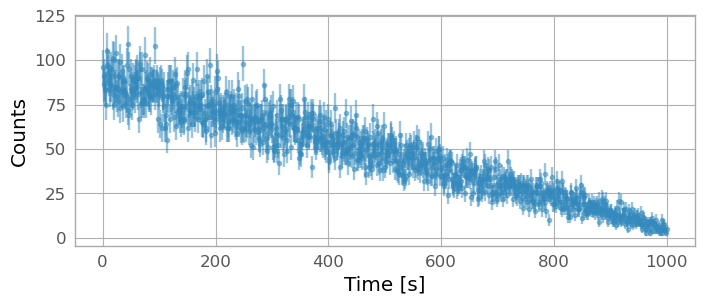

In [12]:
# convert light curve to [TIME, COUNTS] to plot
f=fits.open(lcurve)
TIMEDEL = f["COUNTS"].header["TIMEDEL"]
TSTART = f["COUNTS"].header["TSTART"]
data = f["COUNTS"].data
counts = data["COUNTS"]
times = np.arange(len(counts))*TIMEDEL + TSTART
times_middle = times + 0.5 * TIMEDEL
err_counts = np.sqrt(counts)
f.close()
# ALSO usinf 'fdump'
#comm = (f"fdump infile='{lcurve}[COUNTS][col TIME=#row*TIMEDEL, COUNTS]' clobber=yes outfile=check_lc.txt col='-' row='-' " +
#        f"prhead=no showrow=no showunit=no")
#run_comm(comm, "Converting lc to TIME, COUNTS")
#datalc = pandas.read_table("check_lc.txt", skiprows=0, sep="\s+")
#times = datalc.TIME
#counts = datalc.COUNTS

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
ax.errorbar(times_middle, counts, yerr=err_counts, fmt='.',alpha=0.5)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Counts");

### <span style="color:blue">$\textbf{Exercise}$</span>:
#### Extract the light curve again, but this time with a bin size of 2 s. Plot the light curve as a count rate (i.e., introduce a virtual column in which you divide the counts by the bin size).

In [13]:
# extract lc again but now with a bin size of 2s . Plot counts/binsize
lcurve = "mcrab_bs2.lc"
# Only changes dt ---> dt=2.0
comm = (f"makelc EvtFile={evtfile} Lightcurve={lcurve} length=1000.0 dt=2.0")
#print(comm)
run_comm(comm, "Creating lightcurve")

Creating lightcurve
makelc EvtFile=sim_mcrab_lightcurve_tozero.fits Lightcurve=mcrab_bs2.lc length=1000.0 dt=2.0
SIXTE version 3.0.4
calculate light curve(s) ...
store light curve(s) ...


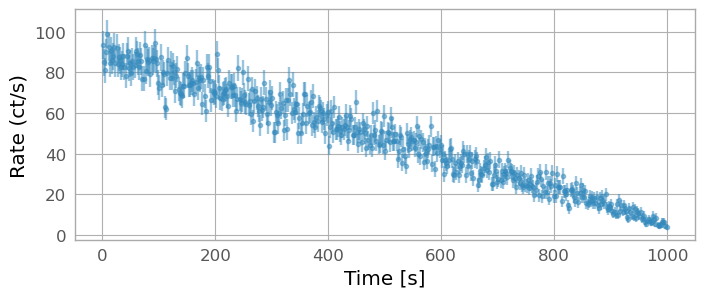

In [14]:
# convert light curve to TIME COUNTS to plot
# With FTOOL fdump:
#comm = (f"fdump infile='{lcurve}[COUNTS][col TIME=#row*TIMEDEL, RATE=COUNTS/TIMEDEL]' clobber=yes " +
#        f"outfile=check_lc_bs2.txt col='-' row='-' prhead=no showrow=no showunit=no")
#run_comm(comm, "Converting lc to TIME, RATE")
#datalc = pandas.read_table("check_lc_bs2.txt", skiprows=0, sep="\s+")
#times = datalc.TIME
#rates = datalc.RATE

# With Astropy:
f=fits.open(lcurve)
TIMEDEL = f["COUNTS"].header["TIMEDEL"]
TSTART = f["COUNTS"].header["TSTART"]
data = f["COUNTS"].data
counts = data["COUNTS"]
times = np.arange(len(counts))*TIMEDEL + TSTART
rates = counts/TIMEDEL
times_middle = times + 0.5 * TIMEDEL
err_rates = np.sqrt(counts)/TIMEDEL
f.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
ax.errorbar(times_middle, rates, yerr=err_rates, fmt='.', alpha=0.5)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Rate (ct/s)");


## 10.3.2 Periodic variability

The **SIMPUT** format also allows defining a source with periodic source variability. This works almost identically to defining a **SIMPUT** with a light curve. The important difference is that now the column in the `TIMING` extension is called `phase` instead of `time`. Additionally, the following header keywords have to be defined:  
- **PHASE0**: phase of periodic oscillation at *t = 0*, which is defined by `MJDREF` and `TIMEZERO` (recommended value between 0 and 1)  
- **PERIOD**: duration of one oscillation period (units given by `TIMEUNIT`)  


### <span style="color:blue">$\textbf{Exercise}$</span>:
#### Download the above SIMPUT of the Crab (https://www.sternwarte.uni-erlangen.de/research/sixte/simput/crab.simput.tgz) and compare it with the time variable SIMPUT you created in Sect. 10.3.1. Note that the light curve extension in the above file you just downloaded has a different name (which?). Can you spot all differences in the light curve extension between these two SIMPUT files?


In [15]:
f_lc = fits.open("mcrab_lightcurve_tozero.fits")
f_pv = fits.open('crab.simput')
print('Time variable SIMPUT from 10.3.1: ')
f_lc.info()
print('Downloaded SIMPUT of the Crab: ')
f_pv.info()

print('Differences between both in the "TIMING" extension')
print(f_lc[3].columns.names)
print(f_pv[3].columns.names)

Time variable SIMPUT from 10.3.1: 
Filename: mcrab_lightcurve_tozero.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SRC_CAT       1 BinTableHDU     44   1R x 12C   [J, 32A, D, D, E, E, E, E, E, 32A, 32A, 32A]   
  2  SPECTRUM      1 BinTableHDU     21   1R x 3C   [1PE(1000), 1PE(1000), 48A]   
  3  TIMING        1 BinTableHDU     21   1000R x 2C   [D, E]   
Downloaded SIMPUT of the Crab: 
Filename: crab.simput
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SRC_CAT       1 BinTableHDU     40   2R x 10C   [J, 11A, E, E, E, E, E, 28A, 9A, 14A]   
  2  SPECTRUM      1 BinTableHDU     21   2R x 3C   [49999E, 49999E, 6A]   
  3  LIGHTCURVE    1 BinTableHDU     28   46R x 2C   [D, D]   
  4  IMAGE         1 ImageHDU        23   (1024, 1024)   uint8   
Differences between both in the "TIMING" extension
['TIME', 'FLUX']
['PHASE', 'FLUX']


## 10.3.3 Power Spectrum

To generate a time variable source with a Power Spectrum, one can also use the `simputfile` call. Ingestigating
it with `plist simputfile` you can see that there are many options to define QPOs (see A.2.1 in the manual for more
information).

#### Add a QPO with a high Q-factor at a frequency of 0.01 Hz to the script that generated *mcrab.fits*. Then rerun the simulation and extract a light curve again.

In [16]:
# recreate simput file
simput_lightcurve_pwr = f'{base}_lightcurve_pwr.fits'
# QPO added with Q1f, Q1Q, Q1rms
comm = (f"simputfile Simput={simput_lightcurve_pwr} Src_Name=first RA=0.0  Dec=0.0 srcFlux={simput_flux} Elow=0.01 Eup=20. " +
        f"NBins=1000 logEgrid=yes Emin=2 Emax=10 MJDREF=55000 XSPECFile=mcrab.xcm Q1f=0.01 Q1Q=180 Q1rms=0.01 clobber=True")
#print(comm)
run_comm(comm, "Creating simputfile with power spectrum")

Creating simputfile with power spectrum
simputfile Simput=mcrab_lightcurve_pwr.fits Src_Name=first RA=0.0  Dec=0.0 srcFlux=2.1306205888361613e-11 Elow=0.01 Eup=20. NBins=1000 logEgrid=yes Emin=2 Emax=10 MJDREF=55000 XSPECFile=mcrab.xcm Q1f=0.01 Q1Q=180 Q1rms=0.01 clobber=True
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Sun Oct 13 18:44:41 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


In [17]:
#run simulation with simputfile from lightcurve
evtfile = f"sim_evt_{base}_lightcurve_pwr.fits"
xml = f"{xmldir}/ld_wfi_ff_large.xml"
comm = (f"sixtesim XMLFile={xml} RA=0. Dec=0. Prefix='' Simput={simput_lightcurve_pwr} " + 
        f"MJDREF=55000 EvtFile={evtfile} Exposure=1000 clobber=yes")
#print(comm)
run_comm(comm, "Running simulation of lightcurve data")

Running simulation of lightcurve data
sixtesim XMLFile=/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab_lightcurve_pwr.fits MJDREF=55000 EvtFile=sim_evt_mcrab_lightcurve_pwr.fits Exposure=1000 clobber=yes
initialize ...
Seed = 4067207283
try to load all spectra ('mcrab_lightcurve_pwr.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


start event pattern analysis ...
start sky projection ...
start Pha2Pi correction ...
run pha2pi correction on event file ... 

cleaning up ...
finished successfully!



In [18]:
# Create lightcurve
lcurve = f"sim_{base}_pwr.lc"
comm = (f"makelc EvtFile={evtfile} Lightcurve={lcurve} length=1000.0 dt=1.0")
#print(comm)
run_comm(comm, "Creating lightcurve")

Creating lightcurve
makelc EvtFile=sim_evt_mcrab_lightcurve_pwr.fits Lightcurve=sim_mcrab_pwr.lc length=1000.0 dt=1.0
SIXTE version 3.0.4
calculate light curve(s) ...
store light curve(s) ...


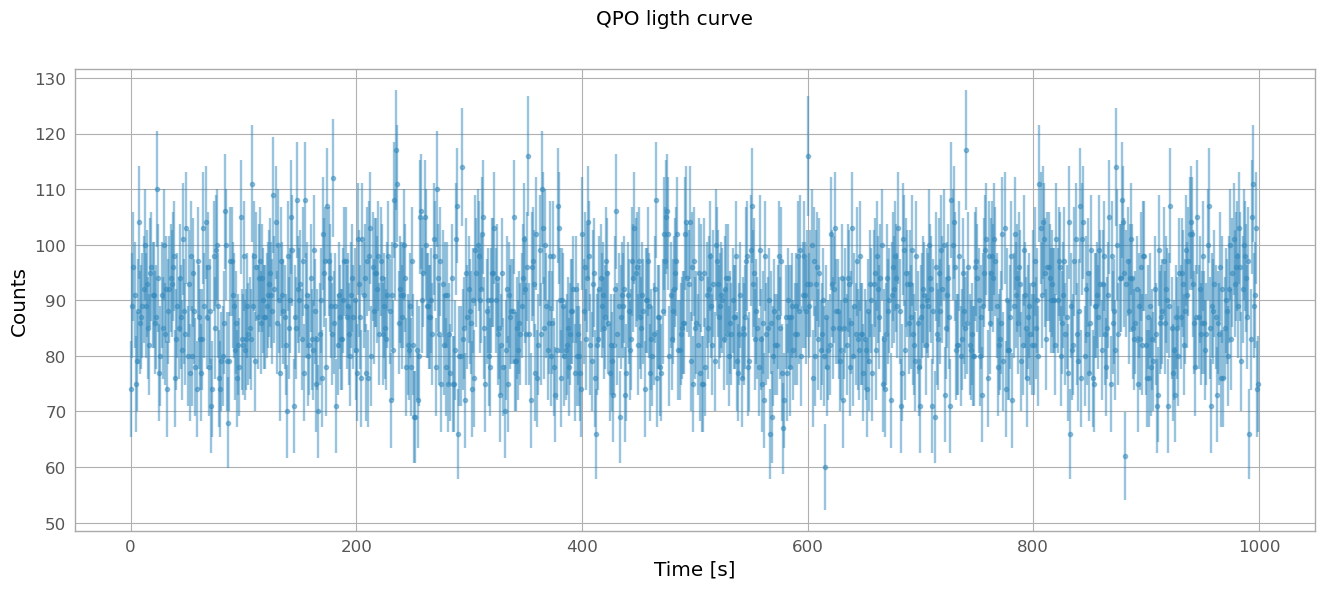

In [19]:
# Plot
f=fits.open(lcurve)
TIMEDEL = f["COUNTS"].header["TIMEDEL"]
TSTART = f["COUNTS"].header["TSTART"]
data = f["COUNTS"].data
counts = data["COUNTS"]
times = np.arange(len(counts))*TIMEDEL + TSTART
times_middle = times + 0.5 * TIMEDEL
err_counts = np.sqrt(counts)
f.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
ax.errorbar(times_middle, counts, yerr=err_counts, fmt='.',alpha=0.5)
fig.suptitle("QPO ligth curve")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Counts");

### <span style="color:blue">$\textbf{Exercise}$</span>:
#### Use the FITS row filter options (`fhelp` `rowfilter`) to select only events that belong to our source and that are in the energy range between 0.5 keV and 1.0 keV.

In [20]:
evtfile = f"sim_evt_{base}_lightcurve_pwr.fits"
lcurve_filt = f"sim_{base}_pwr_filt.lc"
comm = (f"makelc EvtFile=\"{evtfile}[EVENTS][(SIGNAL>=0.5) && (SIGNAL<=1.) && (SRC_ID[1]==1)]\" Lightcurve={lcurve_filt} " +
        f"length=1000. dt=1. clobber=yes")
#print(comm)
run_comm(comm, "Creating lightcurve")

Creating lightcurve
makelc EvtFile="sim_evt_mcrab_lightcurve_pwr.fits[EVENTS][(SIGNAL>=0.5) && (SIGNAL<=1.) && (SRC_ID[1]==1)]" Lightcurve=sim_mcrab_pwr_filt.lc length=1000. dt=1. clobber=yes
SIXTE version 3.0.4
calculate light curve(s) ...
store light curve(s) ...


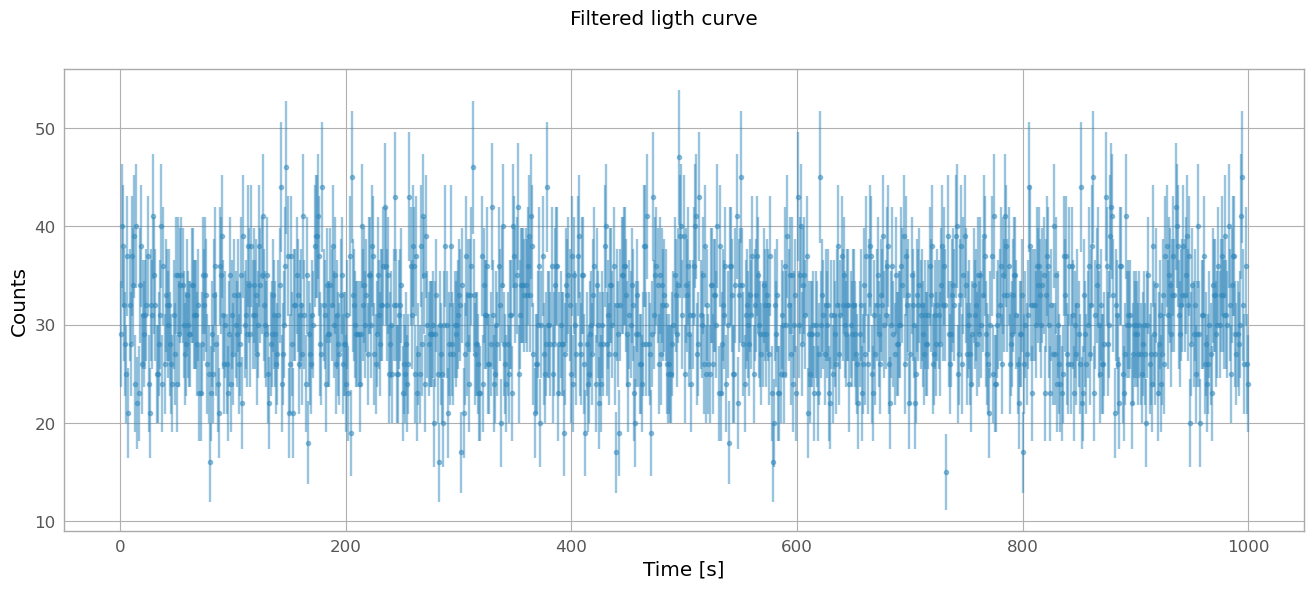

In [21]:
# Plot
f=fits.open(lcurve_filt)
TIMEDEL = f["COUNTS"].header["TIMEDEL"]
TSTART = f["COUNTS"].header["TSTART"]
data = f["COUNTS"].data
counts = data["COUNTS"]
err_counts = np.sqrt(counts)
times = np.arange(len(counts))*TIMEDEL + TSTART
times_middle = times + 0.5 * TIMEDEL
f.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
fig.suptitle("Filtered ligth curve")
ax.errorbar(times_middle, counts, yerr=err_counts, fmt='.',alpha=0.5)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Counts");